Saving common_voice_en_41914135.mp3 to common_voice_en_41914135 (4).mp3

🗣 Transcribing: common_voice_en_41914135 (4).mp3


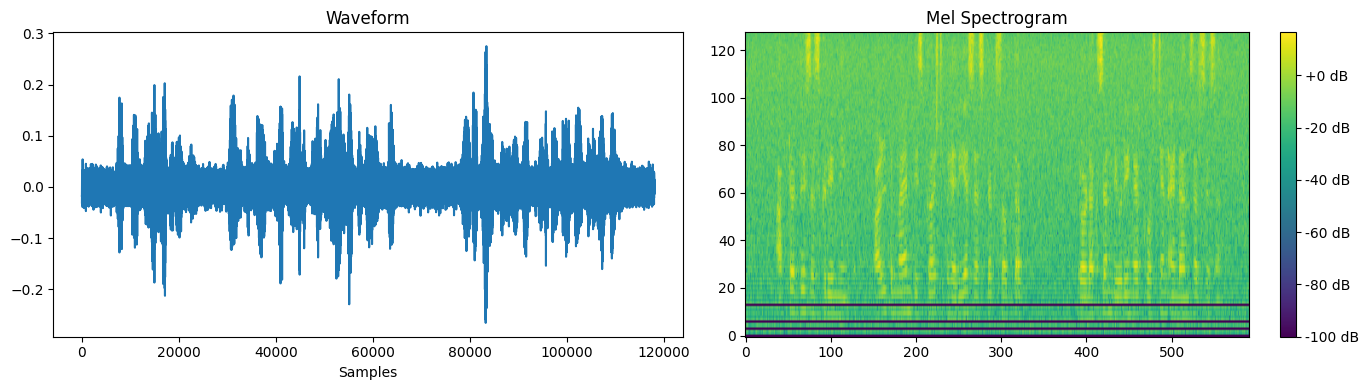

📜 Predicted Transcript: Aftor thisas creety ile teman bis cuest piteous as toc som te orducts on duty that question and ancessissem
✍️ Enter actual spoken sentence (or press Enter to accept prediction):
> after this screening altman discused the various aspects of the question and answer session 
❌ Word Error Rate (WER): 128.57%
✅ Results saved to 'transcription_results.txt'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Step 1: Install Required Libraries
!pip install torchaudio librosa jiwer matplotlib --quiet

# Step 2: Imports
import torch
import torchaudio
import librosa
import numpy as np
from jiwer import wer
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Step 3: Load Pretrained Model
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()
labels = bundle.get_labels()
blank = 0  # For CTC decoding

# Step 4: CTC Decoder
def ctc_decode(token_ids):
    transcript = []
    prev = blank
    for idx in token_ids:
        if idx != prev and idx != blank:
            transcript.append(labels[idx])
        prev = idx
    return ''.join(transcript).replace('|', ' ').strip().capitalize()

# Step 5: Preprocessing Options
def add_noise(waveform, level=0.02):
    return waveform + torch.randn_like(waveform) * level

def denoise_waveform(waveform):
    y = waveform.mean(dim=0).numpy()
    y = librosa.effects.preemphasis(y)
    return torch.tensor(y).unsqueeze(0)

# Step 6: Visualization
def show_waveform_and_spectrogram(waveform, sample_rate):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(waveform[0].numpy())
    plt.title("Waveform")
    plt.xlabel("Samples")

    plt.subplot(1, 2, 2)
    spec = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)
    plt.imshow(spec_db[0].numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title("Mel Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Step 7: Full Transcription Pipeline
def transcribe(path, denoise=True, add_noise_flag=False, noise_level=0.02):
    waveform, sample_rate = torchaudio.load(path)
    display(Audio(waveform.numpy(), rate=sample_rate))  # Play audio

    if denoise:
        waveform = denoise_waveform(waveform)

    if add_noise_flag:
        waveform = add_noise(waveform, noise_level)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    show_waveform_and_spectrogram(waveform, bundle.sample_rate)

    with torch.inference_mode():
        emissions, _ = model(waveform)
    tokens = torch.argmax(emissions[0], dim=-1)
    return ctc_decode(tokens.tolist())

# Step 8: Upload Files
uploaded = files.upload()
results = []

# Step 9: Loop Over Files
for fname in uploaded.keys():
    print(f"\n🗣 Transcribing: {fname}")
    prediction = transcribe(fname, denoise=True, add_noise_flag=True)

    print("📜 Predicted Transcript:", prediction)
    ref = input("✍️ Enter actual spoken sentence (or press Enter to accept prediction):\n> ")
    reference = ref.strip() if ref.strip() else prediction

    error = wer(reference.lower(), prediction.lower())
    print(f"❌ Word Error Rate (WER): {error:.2%}")

    results.append(f"File: {fname}\nPredicted: {prediction}\nReference: {reference}\nWER: {error:.2%}\n")

# Step 10: Save and Download Results
with open("transcription_results.txt", "w") as f:
    f.write("\n\n".join(results))

print("✅ Results saved to 'transcription_results.txt'")
files.download("transcription_results.txt")
